In [2]:
import os, sys

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from utils.utils import Create_Similarity_Model

sns.set_style('whitegrid')
sns.set_context("talk")

2022-07-12 13:52:59.612857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 13:52:59.612875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Now we will create our model

In [3]:
n_nonsimilar = 1
n_similar = 1

### We will look for similarity in the last n_similar parameters of the inputs.

## Load the MVP data for high enough Re

In [9]:
dfSB2M300k_M=pd.read_csv("../../Data/McKeon Data/turb2/Re2300000.txt",  sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB3M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re3000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB4M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re4000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB6M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re6000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB7M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re7000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB10M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re10000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB13M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re13000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])

dfs = [dfSB2M300k_M, dfSB3M_M, dfSB4M_M, dfSB6M_M, dfSB7M_M, dfSB10M_M, dfSB13M_M]
Re_tau = []
Y_ = []
U_ = []
possible_re_tau = [4.229500e+004, 5.453000e+004, 7.647800e+004, 1.022e+005, 1.279200e+005, 1.657e+005, 2.169800e+005]
dic_x = {}
dic_y = {}

for i in range(len(possible_re_tau)):
    possible_y = dfs[i]["y+"].values
    possible_u = dfs[i]["U+"].values
    for j in range(38, len(possible_y)-1):    ### training from y/R > 0.15
        Y_.append(possible_y[j])
        U_.append(possible_u[j])
        Re_tau.append(possible_re_tau[i])

c = list(zip(Y_, Re_tau, U_))
random.shuffle(c)
Y_, Re_tau, U_ = zip(*c)

Y_ = np.log(Y_)
Re_tau = np.log(Re_tau)

dic_x['y+'] = Y_
dic_x['re_tau'] = Re_tau
dic_y['u+'] = np.array(U_)

nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values

0.16427
0.16427
0.16427
0.16427
0.16427
0.16427
0.16427


In [23]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 20                       # Number of model fits we will try to perform
n_epochs_initial = 1000           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0

while successfull_tries < 20:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    if current_loss < 1.0:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

In [14]:
best_model.fit(xtrain, ytrain, epochs = 10000, verbose = 0)
best_model.evaluate(xtrain, ytrain, verbose = 0)

0.009319838136434555

In [15]:
for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
    print('Exponents multiplicating inside the function for ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function: ' + str(multiplication_exponents))

Exponents multiplicating inside the function for y+: [-0.9588488]
Exponents multiplicating outside the function: [0.06983748]


In [16]:
scaling_factor_y = -similarity_exponents
scaling_factor_u = multiplication_exponents

y__ = []
u__ = []
Re_tau = possible_re_tau
Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

for i in range(len(dfs)):
    yplus = dfs[i]['y+']
    uplus = dfs[i]['U+']
    y__.append(yplus / (Re_tau[i] ** scaling_factor_y))
    u__.append(uplus / (Re_tau[i] ** scaling_factor_u))

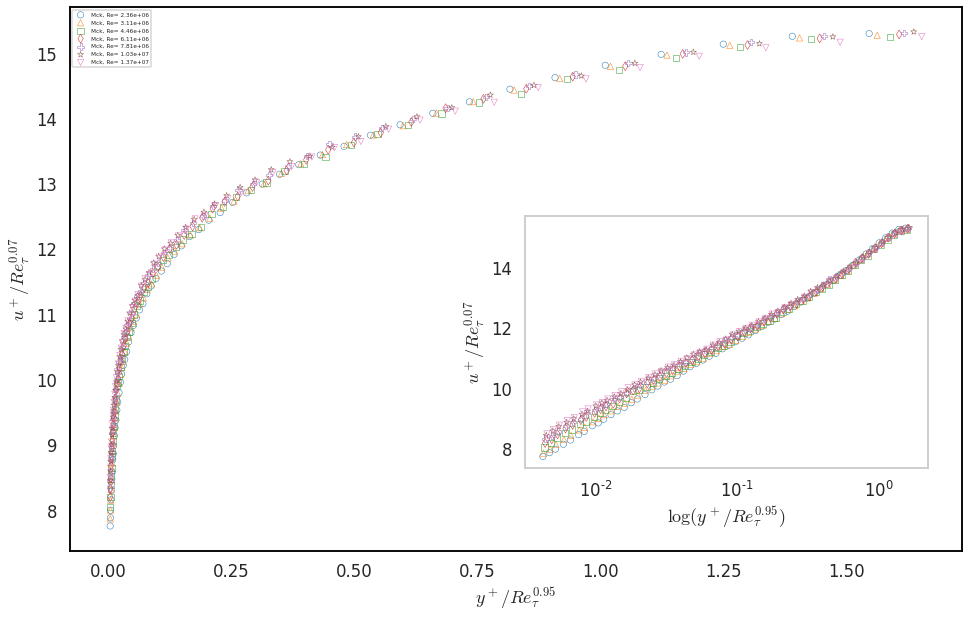

In [19]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(dfs)):
    ax1.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = 'Mck, Re= '+'{:.2e}'.format(Re[i]))
    j+=1

j=0
for i in range(len(dfs)):
    ax2.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Mck, Re= '+'{:.2e}'.format(Re[i]))
    j+=1

ax1.legend(loc = 'upper left', fontsize = 'xx-small')
ax1.set_xlabel(r"$y^+/Re_\tau^{0.95}$")
ax1.set_ylabel(r'$u^+/Re_\tau^{0.07}$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau^{0.95})$")
ax2.set_ylabel(r'$u^+/Re_\tau^{0.07}$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('BarenNet exponents for MVP.pdf', format='pdf', dpi=1200)
plt.show()